# GP Tutorial-E02: Simple GP Implementation in an hour
Author: Wei W. Xing (wxing.me) <br />
Email: wayne.xingle@gmail.com   <br />
Date: 2022-03-23    <br />
Acknowledgement: Many thanks to my student Yu Xing to help to put this tutorial together.   <br />

Abstract: Despite that Gaussian process (GP) has been a long-existing and common used technique, which comes with many useful tutorials, books, articles, and blogs, I found that many (including me as a young student) struggled to put GP into real projects. I believe that the easiest way to learn something is by doing it, instead of preparing all the necessary mathematical backgrounds and diving into theory. Thus, I wrote this tutorials, trying to make it straight-forward to utilize the fancy GP technique, particularly for engineering students.Hopes that you find the tutorial useful.

In this tutorial, we consider a simple case of single output problem, i.e., $y \in \mathcal{R}^1$ is a scalar value, corresponding to $\mathcal{x} \in \mathcal{R}^D$, a $D$-value input vector variable.
<!-- For the tutorial purpose, we do not  -->
<!-- 为了能够降低阅读的难度，我们在Tutorial-E01中将介绍最为简单的GP的代码，也就是指输出$y \in \mathcal{R}^1$为1维标量的情况。 -->
<!-- 为了能够更加方便阅读以及理解，我们将GP整体的类定义拆分成了相互独立的函数.在最后会将全部包括定义成class的代码展示 -->

Let's get started. This implementation is based on Torch, so let's start from importing it.

In [21]:
import torch
import torch.nn as nn
import numpy as np
from matplotlib import pyplot as plt
import os
# from torch.autograd import Variable

print(torch.__version__)
# I use torch (1.11.0) for this work. lower version may not work.

os.environ['KMP_DUPLICATE_LIB_OK'] = 'True' # Fixing strange error if run in MacOS 

JITTER = 1e-6
EPS = 1e-10
PI = 3.1415

2.2.1


#### 1. Generating synthetic data
<!-- 假设真实函数为$y = (6x-2)^2sin(12x-4)$。训练数据 $xtr, ytr$ 分别是$(32, 1)$的列向量，测试数据集$xte, yte$则是选择了100个点，是$(100, 1)$的列向量。 -->
Consider the following function as our target function.
$$y = (6x-2)^2sin(12x-4)$$
We will generate training set $xtr, ytr$ containing 32 samples and testing set $xte, yte$ 100 samples.

xtr.size: torch.Size([32, 1]) ytr.size: torch.Size([32, 1])
xte.size: torch.Size([100, 1]) yte.size: torch.Size([100, 1])


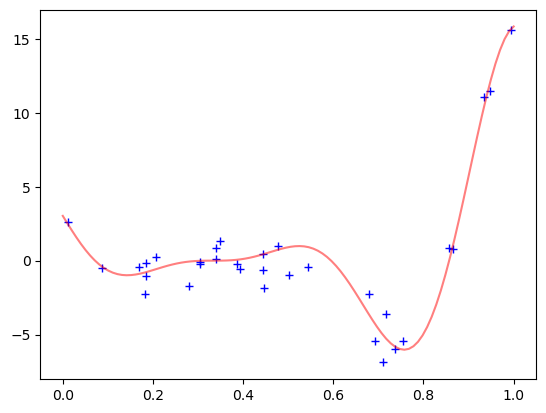

In [22]:
#train_set
xtr = torch.rand(32, 1)
ytr = ((6*xtr - 2)**2) * torch.sin(12*xtr - 4) + torch.randn(32, 1) * 1

#test_set
xte = torch.linspace(0, 1, 100).view(-1,1)
yte = ((6*xte - 2)**2) * torch.sin(12*xte - 4)

#plot the data
print("xtr.size:", xtr.size(), "ytr.size:", ytr.size())
print("xte.size:", xte.size(), "yte.size:", yte.size())
plt.plot(xtr.numpy(), ytr.numpy(), 'b+')
plt.plot(xte.numpy(), yte.numpy(), 'r-', alpha = 0.5)
plt.show()

<!-- #### 2. 设定可优化参数以及核函数 -->
#### 2. Kernel functions and model parameter (hyperparameters)

There are two functions, the mean function and the kernel function, that we need to optimize.
We cannot optimize a "function" easily. Thus we give these functions a particular form to optimize their parameters.
In this tutorial, we specify the mean function as a zero function (and there are nothing to optimize for it.)
For the kernel function, we use the most commonly used automatic relevance determinant (ARD) kernel:
$$k_{ard}(\mathbf{x}, \mathbf{x}') = a \cdot \exp(-\frac{1}{2} \sum_{d=1}^D{ (\frac{x_d-x'_d}{l_d}})^2 )$$
where $a$ is the amplitude of the kernel function, and $l_d$ is called length scale for d-dimensional input ${x}_d$. We can see that $\mathbf{l}$ controls the contribution of each input dimension, e.g., a larger $l_d$ means that $x_d$ has a larger contribution (compared to other dimensions) on the system and vise versa. Thus this kernel has the name "ARD".

One more thing before we start coding. Note that $l_d$ and $a$ are both positive parameters. If we directly define them as torch parameters, they might be pushed to negative during the optimization. Thus we need to make sure that they are positive. One simple way to ensure that is to define them as their logarithmic values and take their exponential values when we use them.

Now let's define the kernel function, which returns the kernel matrix $K$ for two sets for input data.


<!-- 高斯过程中，需要优化的变量是GP的均值函数（中的参数）以及核函数（中的参数）。
在这个例子中我们假设均值函数为0，因此不需要优化他。
<!-- 在这个最简单的情况下，我们已经设定均值函数为0，所以只需要优化协方差函数，也就是这个模型的kernel，因此在下面的cell里里设定的需要优化的参数其实就是kernel中的超参数。 -->
<!-- 我们采用最为经典的 automatic relevance determinant （ARD）核函数： -->
<!-- 这里$l_d$对输入的每个维度进行一个缩放，把那些对系统影响最大的因素（对应着$l_d$很大）筛选出来，所以叫做ARD；$a$ 是kernel的scale。 -->
<!-- 计算kernel matrix的时候我们通常传入的是多个$\mathbf{x}$, -->
<!-- 另外，由于$l_d$ 和 $a$ 必须大于0。因此我们在写程序的时候定义的是 $\log(l_d)$。当需要使用的时候再对其进行指数运算，这样保证我们的参数$\exp{(\log(l_d))}$永远是正的。 -->

<!-- 核函数返回是两个或两组输入之间的核矩阵，我们可以简单地定义核函数： --> 


<!-- 下面的cell中我们定义了核函数，具体的核函数表达式为(SE/OU)：$$k_{ard} = a\cdot exp(-\frac{(x-x')^2-x^2-x'^2}{a})$$ 上述的公式仅是点对点的kernel的值，为了更好的处理大量的数据我们定义的kernel函数将返回一个大小为$(n_X,n_{X2})$的矩阵，其中的第i行，j列元素的含义是：$K_{ij} = k(X_i,X2_j)$。 -->

In [23]:
# define kernel parameters
log_length_scale = nn.Parameter(torch.zeros(xte.size(1)))
log_scale = nn.Parameter(torch.zeros(1))


In [24]:
def kernel(X1, X2, log_length_scale, log_scale): 
    length_scale = torch.exp(log_length_scale)
    K = torch.zeros(X1.size(0), X2.size(0))
    
    for i in range(X1.size(0)):
        for j in range(X2.size(0)):
            for d in range(X1.size(1)):
                K[i,j] = torch.exp(-0.5 * ((X1[i,d] - X2[j,d])**2 / length_scale[d]**2).sum() ) * torch.exp(log_scale)
    return K

K1 = kernel(xtr, xtr, log_length_scale, log_scale)
print(K1)

tensor([[1.0000, 0.9997, 0.9863,  ..., 0.9736, 1.0000, 0.8713],
        [0.9997, 1.0000, 0.9816,  ..., 0.9673, 0.9998, 0.8590],
        [0.9863, 0.9816, 1.0000,  ..., 0.9979, 0.9850, 0.9377],
        ...,
        [0.9736, 0.9673, 0.9979,  ..., 1.0000, 0.9718, 0.9579],
        [1.0000, 0.9998, 0.9850,  ..., 0.9718, 1.0000, 0.8678],
        [0.8713, 0.8590, 0.9377,  ..., 0.9579, 0.8678, 1.0000]],
       grad_fn=<CopySlices>)


*However, we should *NEVER** use a for loop unless we have to. 
Using the for loop will take a lot time and memory we should have not paid.
Let's redo the kernel function in a different way.

In [25]:
def kernel(X1, X2, log_length_scale, log_scale): # 定义核函数没有加linear

    X1 = X1 / log_length_scale.exp()
    X2 = X2 / log_length_scale.exp()

    X1_norm2 = X1 * X1
    X2_norm2 = X2 * X2

    K = -2.0 * X1 @ X2.t() + X1_norm2.expand(X1.size(0), X2.size(0)) + X2_norm2.t().expand(X1.size(0), X2.size(0))  #this is the effective Euclidean distance matrix between X1 and X2.
    K = log_scale.exp() * torch.exp(-0.5 * K)
    return K

K2 = kernel(xtr, xtr, log_length_scale, log_scale)
print(K2)
print( (K1 - K2).norm() )



tensor([[1.0000, 0.9997, 0.9863,  ..., 0.9736, 1.0000, 0.8713],
        [0.9997, 1.0000, 0.9816,  ..., 0.9673, 0.9998, 0.8590],
        [0.9863, 0.9816, 1.0000,  ..., 0.9979, 0.9850, 0.9377],
        ...,
        [0.9736, 0.9673, 0.9979,  ..., 1.0000, 0.9718, 0.9579],
        [1.0000, 0.9998, 0.9850,  ..., 0.9718, 1.0000, 0.8678],
        [0.8713, 0.8590, 0.9377,  ..., 0.9579, 0.8678, 1.0000]],
       grad_fn=<MulBackward0>)
tensor(6.8997e-07, grad_fn=<LinalgVectorNormBackward0>)


We can see that the resulting kernel is the same, whereas the execution time is much faster. You can test a larger xtr to see the difference.

We also need to define the noise $\sigma^2$ of the GP.
To be easier to introduce conjugate prior in a later tutorial, instead of defining $\sigma^2$, we define its inverse $\beta=1/\sigma^2$. Again, we need the value positive.

In [26]:
log_beta = nn.Parameter(torch.ones(1) * -4) # this is a large noise. we optimize to shrink it to a proper value. 

<!-- #### 3. 定义loss损失函数以及优化器 -->
#### 3. Negative log likelihood (nll) 
For almost all regression problems, we aim to minimize a defined loss function. In the GP case, the loss function is the negative log likelihood.
It is negative because we want to minimize as like what we do for a loss function; we take the logarithm of the likelihood because it gives a clear form, and the logarithm does not change the monotonicity of the function.
The log likelihood is defined as:
$$L=-\frac{1}{2}\mathbf{y}^T (\mathbf{K}+\sigma^2 \mathbf{I})^{-1}\mathbf{y}-\frac{1}{2}\log(|\mathbf{K}+\sigma^2 \mathbf{I}|)-\frac{n}{2}log(2\pi)$$
where $\mathbf{y}$ is the observed data arranged as a $N\times1$ vector, $\mathbf{K}$ is the $N\times N$ kernel matrix (of the training data), $\sigma^2$ is the noise variance, and $\mathbf{I}$ is the identity matrix.
Rewrite our loss function in nll, we have
$$nll=\frac{1}{2}\mathbf{y}^T\mathbf{\Sigma}^{-1}\mathbf{y}+\frac{1}{2}\log(|\mathbf{\Sigma}|)+\frac{n}{2}log(2\pi)$$
where we define $\mathbf{\Sigma}=\mathbf{K}+\sigma^2 \mathbf{I}$ as the inverse of the kernel matrix.

We can directly solve code up the nll function and call it in the optimizer. However, we should NOT inverse a matrix unless we have to.
To calculate the nll in a more efficeint way and stable, we can use the following trick:

First compute the cholesky decomposition of the kernel matrix, $\mathbf{\Sigma} = \mathbf{L} \mathbf{L}^T$.
For the first term in the nll, we have,
$$ \mathbf{y}^T (\mathbf{K}+\sigma^2 \mathbf{I})^{-1}\mathbf{y} = \mathbf{y}^T (\mathbf{L} \mathbf{L}^T)^{-1} \mathbf{y} = \mathbf{y}^T \mathbf{L}^{-T} \mathbf{L}^{-1} \mathbf{y}  = (\mathbf{L}^{-1} \mathbf{y})^T \mathbf{L}^{-1} \mathbf{y}  $$
The formula allows us to avoid inverting the kernel matrix by solving a linear system, $\mathbf{L} \mathbf{\gamma} = \mathbf{y}$, which gives us $\mathbf{L}^{-1} \mathbf{y} = \mathbf{\gamma}$.
Once we obtain $\mathbf{\gamma}$, we can calculate the first term in nll as the L2 norm of  $\mathbf{\gamma}$.

<!-- Remember that we should not invert a matrix unless we have to.  -->
<!-- Define , which will becomes handy lately. -->
For the second term in the nll, we have,
$$ \log(|\mathbf{\Sigma}|) = \log(| \mathbf{L} \mathbf{L}^T |) =  \log(|\mathbf{L}| |\mathbf{L}^T|) = \log(\prod_{i=1}^{N} L_{ii} \prod_{i=1}^{N} L_{ii}) = 2\sum_{i=1}^{N}\log(L_{ii})$$

With these two process, the nll becomes:
$$nll=\frac{1}{2} \mathbf{\gamma}^T \mathbf{\gamma} + \sum_{i=1}^{N}\log(L_{ii}) + \frac{n}{2}log(2\pi)$$

Let's code these up now. It will turn out simple.

<!-- 在高斯过程中，我们是通过找极大似然函数对GP进行优化，那么在这里我们的loss就应该是这个模型的似然函数（likelihood）。为了能够更方便计算，通常会对似然函数取log，且为了方便torch中的优化器调用，可以利用求极小值的优化器来对log_likelihood的相反数进行优化。因此下面cell中的negative_log_likelihood函数是模型的-log(likelihood)。
$$-L=\frac{1}{2}y^T\Sigma^{-1}y+\frac{1}{2}log(|\Sigma|)+\frac{n}{2}log(2\pi)$$
其中$\Sigma = K(X,X)+ \frac{1}{\beta} I+ Jitter\cdot I$，是加上噪声影响后的协方差矩阵。

但是，由于对一个矩阵求逆计算复杂且耗时较长，因此我们采用cholesky分解，将协方差矩阵$\Sigma$分解为下三角矩阵$L$和其转置矩阵的乘积，也就是：$\Sigma = LL^T$，因此我们可以先计算中间变量$\alpha = L^{-1}Y$，降低计算的复杂度，具体推导如下：
\begin{aligned}
-L=&\frac{1}{2}y^T\Sigma^{-1}y+\frac{1}{2}log(|\Sigma|)+\frac{n}{2}log(2\pi)\\
=&\frac{1}{2}y^T(LL^T)^{-1}y+\frac{1}{2}log(|LL^T|)+\frac{n}{2}log(2\pi)\\
=&\frac{1}{2}(yL^{-1})^TyL^{-1}+\frac{1}{2}log(|LL^T|)+\frac{n}{2}log(2\pi)\\
=&\alpha^T\alpha+\frac{1}{2}log(|\prod_{i=1}^nL_{ii}|)+\frac{n}{2}log(2\pi)\\
=&\sum_{i=1}^{n}\alpha_i^2+\sum_{i=1}^{n}L_{ii}+\frac{n}{2}log(2\pi)
\end{aligned}
在计算$\Sigma$矩阵行列式时利用cholesky分解的特点，有结论：$|\Sigma|=|\prod_{i=1}^nL_{ii}|$，返回值为标量。 -->

In [27]:
def negative_log_likelihood(X, Y, log_length_scale, log_scale, log_beta):
    y_num = Y.size(0)
    Sigma = kernel(X, X, log_length_scale, log_scale) + log_beta.exp().pow(-1) * torch.eye(X.size(0)) + JITTER * torch.eye(X.size(0))   # add JITTER here to avoid singularity
    
    L = torch.linalg.cholesky(Sigma)
    #option 1 (use this if torch supports)
    gamma,_ = torch.triangular_solve(Y, L, upper = False)
    #option 2
    # gamma = L.inverse() @ Y       # we can use this as an alternative because L is a lower triangular matrix.
    
    nll =  0.5 * (gamma ** 2).sum() +  L.diag().log().sum()  + 0.5 * y_num * torch.log(2 * torch.tensor(PI))
    return nll

<!-- 当设定好loss函数以后就可以借用torch.optim中的优化器对模型进行优化，求极小值。 -->
#### 4. Calling the optimizer
With the loss/nll defined, we can simply call an optimizer to minimize the loss.

In [28]:
def train_adam(X, Y, log_length_scale, log_scale, log_beta, niter = 50, lr = 0.001):
    optimizer = torch.optim.Adam([log_beta, log_length_scale, log_scale], lr = lr)
    optimizer.zero_grad()
    for i in range(niter):
        optimizer.zero_grad()
        # self.update()
        loss = negative_log_likelihood(X, Y, log_length_scale, log_scale, log_beta)
        loss.backward()
        optimizer.step()

        # print the nll
        # print('iter', i, ' nnl:', loss.item())
        print('iter', i, 'nnl:{:.5f}'.format(loss.item()))
        # print the likelihood
        # print('iter', i, 'nnl:{:.5f}'.format(loss.item()),'likelihood:{:.9f}'.format((-loss).exp().item()) )
        
train_adam(xtr, ytr,log_length_scale, log_scale, log_beta, 5, 0.01)

iter 0 nnl:99.88548
iter 1 nnl:99.78800
iter 2 nnl:99.69115
iter 3 nnl:99.59495
iter 4 nnl:99.49941


<!-- #### 4. 预测 Predictive Prosterior  -->
#### 5. Predictive posterior 

With the hyperparameters optimized, we can now calculate the predictive posterior following the standard formulations,
\begin{aligned}
&\mu=\mathbf{k}^* \Sigma^{-1} \mathbf{y}\\
&s^2=\mathbf{k}_{**}- (\mathbf{k}^*)^T \mathbf{\Sigma}^{-1} \mathbf{k}^* + {1}/{\beta}\\
\end{aligned}
As we mentioned, we should not invert a matrix unless we have to.
Again, we utilize the cholesky decomposition to obtain the predictive posterior.
Let define $\mathbf{\Sigma}^{-1} \mathbf{y} =  \mathbf{\alpha}$, which is conventionally used in the literature and open source codes. 
The advantage of introducing $\mathbf{\alpha}$ is that 1) we can use the cholesky decomposition to compute the predictive posterior; 2) it saves storage and provides quick prediction of the posterior (no more inversion required).
<!-- Using $\mathbf{\gamma}$,  -->
Using $\mathbf{L}$ to get $\mathbf{\alpha}$, we solve the $\mathbf{L} \mathbf{\gamma} = \mathbf{y}$ first and then compute $\mathbf{L}^T \mathbf{y} = \mathbf{\gamma}$, which, as you might have seen, is sometimes written in a compact way
$$\mathbf{\alpha} = \mathbf{L}^T \backslash \mathbf{L} \backslash \mathbf{y}$$

The computation of $(\mathbf{k}^*)^T \mathbf{\Sigma}^{-1} \mathbf{k}^*$ is similar to the computation of $\mathbf{\gamma}^T \mathbf{\gamma}$ in the previous section.

<!-- 在预测模块，需要预测的主要为预测点的均值与方差，值得注意的是虽然模型假设均值函数为0但是预测点的均值不必须为0由预测值来决定。预测点的均值与方差表达式如下：
\begin{aligned}
&\mu=k(x^*,x)\Sigma^{-1}Y=k(x^*,x)(LL^T)^{-1}Y\\
&s^2=k_{**}-k(x,x^*)\Sigma^{-1}k(x^*,x)
\end{aligned}
为了方便计算，我们依旧利用cholesky分解，$\Sigma=LL^T$，并且在方差部分由于函数设置是可以多个预测点同时进行计算，所以方差部分，我们仅需要预测方差矩阵的对角线部分的数值。因为噪声较小，所以课假设噪声不影响求逆。$$diag(s^2)=a\cdot I-diag(k(x,x^*)(LL^T)^{-1}k(x^*,x))+\frac{1}{\beta}\cdot I$$ -->

In [29]:
def forward(X, Xte, log_length_scale, log_scale, log_beta, Y):
    n_test = Xte.size(0)
    Sigma = kernel(X, X, log_length_scale, log_scale) + log_beta.exp().pow(-1) * torch.eye(
        X.size(0)) + JITTER * torch.eye(X.size(0))
    kx = kernel(X, Xte, log_length_scale, log_scale)
    L = torch.cholesky(Sigma)
    
    # option 1
    mean = kx.t() @ torch.cholesky_solve(Y, L)  # torch.linalg.cholesky()
    # option 2
    # mean = kx @ torch.L.t().inverse() @ L.inverse() @ Y
    
    # LinvKx = L.inverse() @ kx.t()  # TODO: the inverse for L should be cheap. check this.
        # torch.cholesky_solve(kx.t(), L)
    LinvKx,_ = torch.triangular_solve(kx, L, upper = False)
    # option 1, standard way
    # var_diag = kernel(Xte, Xte, log_length_scale, log_scale).diag().view(-1,1) - (LinvKx.t() @ LinvKx).diag().view(-1, 1)
    # option 2, a faster way
    var_diag = log_scale.exp().expand(n_test, 1) - (LinvKx**2).sum(dim = 0).view(-1, 1)
    var_diag = var_diag + log_beta.exp().pow(-1)
    return mean, var_diag

#### 6. Testing and validating
let try our GP model on the synthetic data and see how well it does.

iter 0 nnl:99.40457
iter 1 nnl:98.49126
iter 2 nnl:97.65099
iter 3 nnl:96.89208
iter 4 nnl:96.22300
iter 5 nnl:95.65187
iter 6 nnl:95.18575
iter 7 nnl:94.82941
iter 8 nnl:94.58382
iter 9 nnl:94.44400
iter 10 nnl:94.39706
iter 11 nnl:94.42090
iter 12 nnl:94.48492
iter 13 nnl:94.55383
iter 14 nnl:94.59438
iter 15 nnl:94.58270
iter 16 nnl:94.50893
iter 17 nnl:94.37719
iter 18 nnl:94.20201
iter 19 nnl:94.00328
iter 20 nnl:93.80136
iter 21 nnl:93.61302
iter 22 nnl:93.44846
iter 23 nnl:93.30984
iter 24 nnl:93.19206
iter 25 nnl:93.08519
iter 26 nnl:92.97729
iter 27 nnl:92.85612
iter 28 nnl:92.70982
iter 29 nnl:92.52679
iter 30 nnl:92.29567
iter 31 nnl:92.00517
iter 32 nnl:91.64431
iter 33 nnl:91.20281
iter 34 nnl:90.67206
iter 35 nnl:90.04636
iter 36 nnl:89.32447
iter 37 nnl:88.50970
iter 38 nnl:87.60675
iter 39 nnl:86.61389
iter 40 nnl:85.51698
iter 41 nnl:84.29971
iter 42 nnl:82.96611
iter 43 nnl:81.54935
iter 44 nnl:80.10100
iter 45 nnl:78.66888
iter 46 nnl:77.27243
iter 47 nnl:75.89909
it

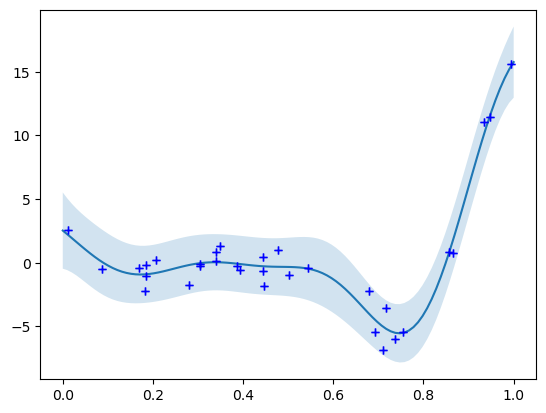

In [30]:
train_adam(xtr, ytr, log_length_scale, log_scale, log_beta, 100, 0.1)
with torch.no_grad():
    ypred, yvar = forward(xtr, xte, log_length_scale, log_scale, log_beta, ytr)
    
plt.fill_between(xte.squeeze().numpy(), ypred.squeeze().detach().numpy() - 1.96 * np.sqrt(yvar.squeeze().detach().numpy()), ypred.squeeze().detach().numpy() + 1.96 * np.sqrt(yvar.squeeze().detach().numpy()), alpha=0.2, label='95% Confidence interval')
plt.plot(xte.squeeze().numpy(), ypred.squeeze().detach().numpy(), label='Predictive mean')
plt.plot(xtr.detach().numpy(), ytr.detach().numpy(), 'b+')
plt.plot(xtr.numpy(), ytr.numpy(), 'b+')
plt.show()